<h1><center>CSCI - 4146 - The Process of Data Science - Summer 2022</h1></center>
<h1><center>Assignment 1</h1></center>

<b>Sarthak Pandit</b>  
<b>B00900388</b>  


<b>Sagar Devesh</b>  
<b>B00905507</b>  

In [1]:
import pandas as pd
import warnings
%matplotlib inline
import geopandas as gpd 
import shapefile as shp 
import folium
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm
sns.set()
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pandas_profiling import ProfileReport 

### _Question 1: Data exploration and preprocessing_

In [28]:

#Data source
filePath = "C:\Study material\Dalhousie Courses\Second term\Process of data science\ASN1\Dataset\INVESTIGATION SPECIAL COORDINATES\AUSTRALIA"

#Using random sampling technique, taking samples from each dataset source and combining it
df2017 = pd.read_csv("modis_2017_Australia.csv").sample(n= 50000)
df2018 = pd.read_csv("modis_2018_Australia.csv").sample(n= 50000)
df2019 = pd.read_csv("modis_2019_Australia.csv").sample(n= 50000)
df2020 = pd.read_csv("modis_2020_Australia.csv").sample(n= 50000)
df2021 = pd.read_csv("fire_nrt_M-C61_212899.csv").sample(n= 1000)


df = pd.concat([df2017,df2018,df2019,df2020,df2021])


In [5]:
#Total data size is 200k records after subsampling
df.shape

(201000, 15)

### _Question 1.1(a): Data quality reports for continuous and categorical features_

### _Continuous features_
Continous features include the following - 
1. Minimum 
2. 1st quartile
3. Mean
4. 2nd quartile - Median
5. 3rd quartile
6. Maximum
7. Standard deviation
8. Total num of instances
9. % missing values
10. Cardinality - Number of unqiue values for a given feature

In [6]:
#Defining function to generate data quality report for continous features in the dataset
def build_continuous_features_report(data_df):
    
    stats = {
        "Count": len,
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,
        "Card.": lambda df: df.nunique(),
        "Min": lambda df: df.min(),
        "1st Qrt.": lambda df: df.quantile(0.25),
        "Mean": lambda df: df.mean(),
        "Median": lambda df: df.median(),
        "3rd Qrt": lambda df: df.quantile(0.75),
        "Max": lambda df: df.max(),
        "Std. Dev.": lambda df: df.std(),
    }
    contin_feat_names = data_df.select_dtypes("number").columns
    continuous_data_df = data_df[contin_feat_names]

    report_df = pd.DataFrame(index=contin_feat_names, columns=stats.keys())

    for stat_name, fn in stats.items():
        # NOTE: ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(continuous_data_df)

    return report_df

In [7]:
build_continuous_features_report(df)

Count    Miss %   Card.        Min    1st Qrt.        Mean  \
latitude    201000  0.000000  134154  -43.41500  -29.029300  -21.740003   
longitude   201000  0.000000  147793    9.93736  127.033375  135.111054   
brightness  201000  0.000000    2513  300.00000  317.900000  332.699920   
scan        201000  0.000000     190    1.00000    1.100000    1.655664   
track       201000  0.000000      86    1.00000    1.000000    1.225077   
acq_time    201000  0.000000     917    0.00000  230.000000  623.032199   
confidence  201000  0.000000     101    0.00000   56.000000   70.781090   
bright_t31  201000  0.000000    1473  265.70000  295.800000  303.143792   
frp         201000  0.000000    8162    0.00000   14.400000   69.260294   
type        201000  0.497512       3    0.00000    0.000000    0.015580   

               Median    3rd Qrt         Max   Std. Dev.  
latitude    -19.81835  -15.16730    48.61631    9.185779  
longitude   133.65115  145.56105   153.58360   13.231096  
brightness  328.50000  341.30000   506.60000   23.191771  
scan          1.30000    1.90000     4.80000    0.847876  
track         1.10000    1.40000     2.00000    0.256566  
acq_time    443.00000  634.00000  2359.00000  531.595750  
confidence   74.00000   90.00000   100.00000   22.936644  
bright_t31  302.90000  309.60000   400.10000   10.779346  
frp          28.00000   61.90000  9512.80000  167.995053  
type          0.00000    0.00000     3.00000    0.179381

### _Categorical Features_
Categorical features report includes:
1. Mode - most repeated value (value with highest frequency)
2. 2nd mode - 2nd most repeated value
3. Frequency of mode
4. Proportion of mode in the dataset
5. Frequency of 2nd mode
6. Proportion of 2nd mode in the dataset
7. % missing values 
8. Cardinality - number of unique values for a given feature

In [8]:
#Defining function to generate data quality report for categorical features in the dataset
def build_categorical_features_report(data_df):

    def _mode(df):
        return df.apply(lambda ft: ft.mode().to_list())

    def _mode_freq(df):
        return df.apply(lambda ft: ft.value_counts()[ft.mode()].sum())

    def _second_mode(df):
        return df.apply(lambda ft: ft[~ft.isin(ft.mode())].mode().to_list())

    def _second_mode_freq(df):
        return df.apply(
            lambda ft: ft[~ft.isin(ft.mode())]
            .value_counts()[ft[~ft.isin(ft.mode())].mode()]
            .sum()
        )

    stats = {
        "Count": len,
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,
        "Card.": lambda df: df.nunique(),
        "Mode": _mode,
        "Mode Freq": _mode_freq,
        "Mode %": lambda df: _mode_freq(df) / len(df) * 100,
        "2nd Mode": _second_mode,
        "2nd Mode Freq": _second_mode_freq,
        "2nd Mode %": lambda df: _second_mode_freq(df) / len(df) * 100,
    }

    feature_names = data_df.select_dtypes(exclude="number").columns
    continuous_data_df = data_df[feature_names]
    report_df = pd.DataFrame(index=feature_names, columns=stats.keys())
    
    
    for stat_name, fn in stats.items():
        # NOTE: ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(continuous_data_df)

    return report_df

In [9]:
df.describe(exclude=['number'])

acq_date satellite instrument    version daynight
count       201000    201000     201000  201000.00   201000
unique        1473         2          1       3.00        2
top     2020-01-04      Aqua      MODIS       6.03        D
freq          2343    116209     201000  150000.00   155204

In [10]:
#Calculating categorical feature data quality report for all the non-numerical features
df1 = build_categorical_features_report(df[["daynight"]])
df2 = build_categorical_features_report(df[["acq_date"]])
df3 = build_categorical_features_report(df[["satellite"]])
df4 = build_categorical_features_report(df[["daynight"]])

#Combining generated report for all the features
dfs = pd.concat([df1,df2,df3,df4])
dfs

Count  Miss %  Card. Mode  Mode Freq     Mode % 2nd Mode  \
daynight   201000     0.0      2  NaN     155204  77.215920      NaN   
acq_date   201000     0.0   1473  NaN       2343   1.165672      NaN   
satellite  201000     0.0      2  NaN     116209  57.815423      NaN   
daynight   201000     0.0      2  NaN     155204  77.215920      NaN   

           2nd Mode Freq  2nd Mode %  
daynight           45796   22.784080  
acq_date            1404    0.698507  
satellite          84791   42.184577  
daynight           45796   22.784080

### _Question 1.1(b): Correlational Heat Map_

In [11]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

#### Pandas Profiling

Pandas-profiling is an opend source python module which generates profile reports from a pandas dataframe. With this module, we can do a quick exploratory data analysis. We used this library to get additional insights into the dataset.
[1](https://github.com/ydataai/pandas-profiling)

In [12]:
ProfileReport(df, title="Pandas Profile Report for raw_data").to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### _Question 1.1(c): Data quality issues and data quality plan_

#### Missing values:
We identified that there is a significant number of missing values for the 'type' feature. As per the report generated above with pandas profiling, we can see (in the _Missing values_ section) that the type feature has 1000 missing values in the 'df' dataframe. 

Also, the 'type' feature does not play a significant role in predicting the confidence of the incident. Hence, we will go ahead and drop this feature while training the model later on. However, for the time being, we will drop all the rows containing missing values in the type feature in the preprocessing step.

#### Random sampling:
We have used the random sampling technique to take samples from each dataset source and then combined it to obtain one dataset. We performed this step at the beginning of this notebook. 

#### Categorical features:
There are categorical features in the dataset such as 'satellite' and 'daynight'. It is important to convert them into numeric representations using one hot encoding or by simply mapping them to binary values of 0's and 1's. We will perform the same during the preprocessing step. 

#### Converting the acq_date column to datetime format: [2](https://stackoverflow.com/questions/32012012/pandas-resample-timeseries-with-groupby)
The acq_date column has the date values in the string format, and we will convert it to the datetime format during data preprocessing. 

#### Cardinality of features
Categorical features whose cadinality is too low or too high can be dropped as it will not provide value to our model. In our dataset, we will go ahead and drop the 'instrument' and 'version' features as their cardinality is too low. 

#### Reset index
The dataset that we obtained after clubbing the 5 datasets has unordered index. We will reset the index of this dataframe during preprocessing. 

### _Question 1.2 : Data Preprocessing_

In [29]:
#Removing any 'Nan' values from the dataset
df = df.dropna() 
df.count()

latitude      200000
longitude     200000
brightness    200000
scan          200000
track         200000
acq_date      200000
acq_time      200000
satellite     200000
instrument    200000
confidence    200000
version       200000
bright_t31    200000
frp           200000
daynight      200000
type          200000
dtype: int64

In [30]:
df.isnull().sum().sort_values(ascending=False) # to check for null values

latitude      0
longitude     0
brightness    0
scan          0
track         0
acq_date      0
acq_time      0
satellite     0
instrument    0
confidence    0
version       0
bright_t31    0
frp           0
daynight      0
type          0
dtype: int64

In [31]:
df['satellite'] = df['satellite'].map({'Terra': 1, 'Aqua': 0}) # Mapping 'Terra' to 1 and 'Aqua' to 0 
df['daynight'] = df['daynight'].map({'D':1, 'N':0}) # Mapping Day ('D') to 1 and Night ('N') to 0
df.head()

latitude  longitude  brightness  scan  track    acq_date  acq_time  \
121457  -12.1764   134.7447       325.7   1.3    1.1  2017-08-28       429   
247926  -15.6175   143.5351       342.8   1.1    1.0  2017-12-06       404   
89536   -12.8401   130.7018       309.7   1.1    1.0  2017-07-02      1401   
147933  -15.8805   128.7135       341.9   1.7    1.3  2017-09-19       530   
95169   -25.0935   120.8208       347.2   1.7    1.3  2017-07-19       233   

        satellite instrument  confidence version  bright_t31    frp  daynight  \
121457          0      MODIS          62     6.2       309.0   15.9         1   
247926          0      MODIS          87     6.2       313.7   35.4         1   
89536           1      MODIS          78     6.2       290.6   10.0         0   
147933          0      MODIS          86     6.2       310.9   66.0         1   
95169           1      MODIS          94     6.2       298.3  116.8         1   

        type  
121457   0.0  
247926   0.0  
89536    0.0  
147933   0.0  
95169    0.0

In [32]:
df['acq_date'] = pd.to_datetime(df['acq_date'], format='%Y-%m-%d') # Converting the acq_date values to datetime format
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 121457 to 148054
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   latitude    200000 non-null  float64       
 1   longitude   200000 non-null  float64       
 2   brightness  200000 non-null  float64       
 3   scan        200000 non-null  float64       
 4   track       200000 non-null  float64       
 5   acq_date    200000 non-null  datetime64[ns]
 6   acq_time    200000 non-null  int64         
 7   satellite   200000 non-null  int64         
 8   instrument  200000 non-null  object        
 9   confidence  200000 non-null  int64         
 10  version     200000 non-null  object        
 11  bright_t31  200000 non-null  float64       
 12  frp         200000 non-null  float64       
 13  daynight    200000 non-null  int64         
 14  type        200000 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(4), ob

In [33]:
# dropping the categorical features 'instrument' and 'version' due to their low cardinality.
df = df.drop(['instrument', 'version'], axis=1)  
df.head()

latitude  longitude  brightness  scan  track   acq_date  acq_time  \
121457  -12.1764   134.7447       325.7   1.3    1.1 2017-08-28       429   
247926  -15.6175   143.5351       342.8   1.1    1.0 2017-12-06       404   
89536   -12.8401   130.7018       309.7   1.1    1.0 2017-07-02      1401   
147933  -15.8805   128.7135       341.9   1.7    1.3 2017-09-19       530   
95169   -25.0935   120.8208       347.2   1.7    1.3 2017-07-19       233   

        satellite  confidence  bright_t31    frp  daynight  type  
121457          0          62       309.0   15.9         1   0.0  
247926          0          87       313.7   35.4         1   0.0  
89536           1          78       290.6   10.0         0   0.0  
147933          0          86       310.9   66.0         1   0.0  
95169           1          94       298.3  116.8         1   0.0

In [36]:
df.reset_index(drop=True, inplace=True)
df.head()

latitude  longitude  brightness  scan  track   acq_date  acq_time  \
0  -12.1764   134.7447       325.7   1.3    1.1 2017-08-28       429   
1  -15.6175   143.5351       342.8   1.1    1.0 2017-12-06       404   
2  -12.8401   130.7018       309.7   1.1    1.0 2017-07-02      1401   
3  -15.8805   128.7135       341.9   1.7    1.3 2017-09-19       530   
4  -25.0935   120.8208       347.2   1.7    1.3 2017-07-19       233   

   satellite  confidence  bright_t31    frp  daynight  type  
0          0          62       309.0   15.9         1   0.0  
1          0          87       313.7   35.4         1   0.0  
2          1          78       290.6   10.0         0   0.0  
3          0          86       310.9   66.0         1   0.0  
4          1          94       298.3  116.8         1   0.0

In [37]:
df.columns.values

array(['latitude', 'longitude', 'brightness', 'scan', 'track', 'acq_date',
       'acq_time', 'satellite', 'confidence', 'bright_t31', 'frp',
       'daynight', 'type'], dtype=object)

In [39]:
# Since 'frp' is our target feature, reordering the columns so that our target feature appears at the end of the dataframe.
columns_reordered = ['latitude', 'longitude', 'brightness', 'scan', 'track', 'acq_date',
       'acq_time', 'satellite', 'confidence', 'bright_t31',
       'daynight', 'type', 'frp']
df = df[columns_reordered]
df.head()

latitude  longitude  brightness  scan  track   acq_date  acq_time  \
0  -12.1764   134.7447       325.7   1.3    1.1 2017-08-28       429   
1  -15.6175   143.5351       342.8   1.1    1.0 2017-12-06       404   
2  -12.8401   130.7018       309.7   1.1    1.0 2017-07-02      1401   
3  -15.8805   128.7135       341.9   1.7    1.3 2017-09-19       530   
4  -25.0935   120.8208       347.2   1.7    1.3 2017-07-19       233   

   satellite  confidence  bright_t31  daynight  type    frp  
0          0          62       309.0         1   0.0   15.9  
1          0          87       313.7         1   0.0   35.4  
2          1          78       290.6         0   0.0   10.0  
3          0          86       310.9         1   0.0   66.0  
4          1          94       298.3         1   0.0  116.8

### _Question 1.3(a) : Dates on which bushfires present the high number of incidents_
[6](https://stackoverflow.com/questions/59631533/pandas-counting-rows-with-dates)

In [123]:
cnt = df.groupby('acq_date').size()
cnt = pd.DataFrame(cnt, columns=['no. of incidents']).sort_values('no. of incidents', ascending=False)
cnt


no. of incidents
acq_date                    
2020-01-04              2355
2020-01-02              1390
2020-01-03              1348
2020-01-01              1150
2019-12-30              1142
...                      ...
2017-01-14                 4
2020-12-28                 3
2018-02-02                 3
2017-01-02                 1
2020-03-06                 1

[1461 rows x 1 columns]

As per the above output, 4th January, 2020 presents the highest number of incidents (2355), followed by 2nd January 2020 (1390), and then 3rd January 2020 (1348).

### _Question 1.3(b): Attributes that are useful to predict the confidence of an incident_

As per the correlational heat map plotted earlier, 'confidence' of an incident is highly correlated to 'brightness'. Hence, 'brightness' is the most useful attribute in predicting the confidence of an incident. Furthermore, 'confidence' also appears to be correlated to 'frp' and 'bright_t31' features. 

As per the dataset description on Kaggle, confidence values are intended to help the users gauge the quality of individual fire pixels. High confidence values indicate higher saturation of the fire pixels and high relative temperature anomaly. Lower confidence values typically indicate areas of sun glint (less brightness) and lower relative temperature anomaly. Hence, lower confidence value must typically indicate lower brightness and vice versa. Therefore, brightness is the most import attribute in predicting confidence. 

Moreover, since 'brightness' attribute is also highly correlated to attributes 'bright_t31' and 'frp', resultingly 'bright_t31' and 'frp' are also important attributes in predicting the confidence of an incident. (Analogous to transitive property: if a=b and b=c, then a=c)

### _2. Spatio-temporal data_

### _Question 2.1: Plot geographical heatmap of FRP for Aqua area_

In [2]:
from folium import plugins


In [5]:
data = pd.read_csv('modis_2017_Australia.csv')
data.head()

latitude  longitude  brightness  scan  track    acq_date  acq_time  \
0  -23.9083   147.2966       320.1   1.7    1.3  2017-01-01        47   
1  -23.6890   150.0994       314.3   2.7    1.6  2017-01-01        47   
2  -23.5908   150.1676       315.8   2.7    1.6  2017-01-01        47   
3  -22.4119   148.8484       316.7   2.1    1.4  2017-01-01        47   
4  -20.5897   147.6421       320.7   1.6    1.3  2017-01-01        47   

  satellite instrument  confidence  version  bright_t31   frp daynight  type  
0     Terra      MODIS          53      6.2       296.6  17.6        D     0  
1     Terra      MODIS          22      6.2       289.3  30.0        D     0  
2     Terra      MODIS          33      6.2       291.7  35.4        D     0  
3     Terra      MODIS          26      6.2       295.3  25.8        D     0  
4     Terra      MODIS          34      6.2       299.6  19.0        D     0

In [6]:
# getting data only for aqua area
data_modified = data[data['satellite']=='Aqua']
data_modified.head()

latitude  longitude  brightness  scan  track    acq_date  acq_time  \
35  -31.4349   151.8703       329.8   1.5    1.2  2017-01-01       328   
36  -29.2575   152.9995       333.5   1.2    1.1  2017-01-01       329   
37  -29.2560   153.0119       330.5   1.2    1.1  2017-01-01       329   
38  -27.3290   149.9916       345.4   1.7    1.3  2017-01-01       330   
39  -27.3156   150.0073       345.7   1.7    1.3  2017-01-01       330   

   satellite instrument  confidence  version  bright_t31   frp daynight  type  
35      Aqua      MODIS          83      6.2       290.9  40.2        D     0  
36      Aqua      MODIS          63      6.2       309.1  21.2        D     0  
37      Aqua      MODIS          44      6.2       307.5  16.4        D     0  
38      Aqua      MODIS          88      6.2       309.9  59.9        D     0  
39      Aqua      MODIS          88      6.2       311.4  59.8        D     0

In [7]:
# extracting the map of Australia from world map.
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
aus = world.loc[world['name'] == 'Australia']


#### Justification the for choice of aggregation
We have used median as the aggregation method to get FRP values for each day in the year 2017. We have chosen median for aggregation as it is not affected by extremely large values or outliers. Since the values in the 'frp' column are skewed, we believe median will provide better results as compared to mean or any other method of aggregation.

[1](https://stackoverflow.com/questions/32012012/pandas-resample-timeseries-with-groupby)

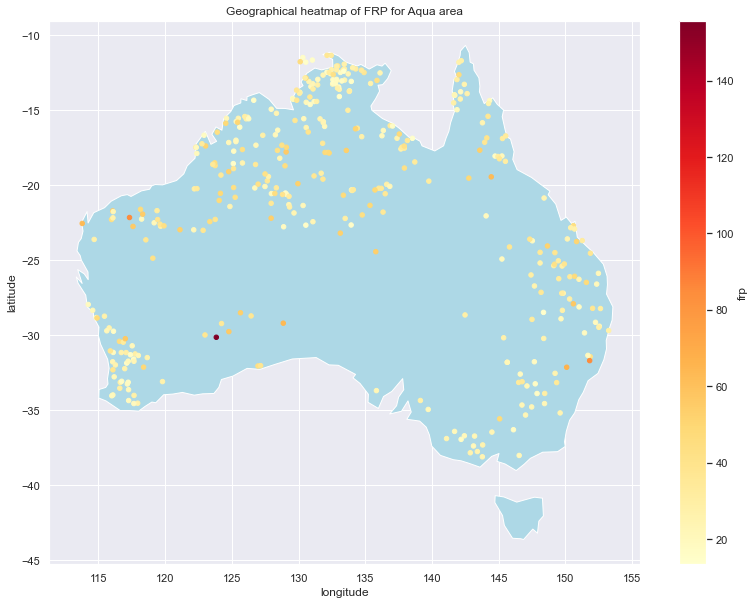

In [9]:
fig, ax = plt.subplots(figsize=(14,10))
aus_map = aus.plot(figsize =(10,10), color='lightblue', ax=ax)


med_frp = data_modified.groupby(pd.Grouper(key='acq_date'))['frp'].median()

final_df = []
for date, frp in med_frp.items():
    final_df.append(data_modified[(data_modified['acq_date']==date) & (data_modified['frp']==frp)])

geo_df_plot = pd.concat(final_df)

geo_df_plot.plot(x='longitude', y='latitude', kind='scatter', title='Geographical heatmap of FRP for Aqua area', legend=True, c='frp', colormap='YlOrRd', ax=ax);


Above is a heatmap that we have plotted using the plot function. Higher values of frp are depicted by the darker shade, and lower values by lighter shade
[3](https://towardsdatascience.com/the-easiest-way-to-plot-data-from-pandas-on-a-world-map-1a62962a27f3)

However, we have also plotted a geographic heatmap using folium for the same 'geo_df_plot' dataframe , as shown below.
[4](https://stackoverflow.com/questions/54752175/add-heatmap-to-a-layer-in-folium)

In [10]:
lat = geo_df_plot['latitude'].median()
lon = geo_df_plot['longitude'].median()
m = folium.Map(location=[lat, lon],tiles = "Stamen Terrain",zoom_start=4)
points = geo_df_plot[['latitude', 'longitude', 'frp']]
plugins.HeatMap(points, radius=14).add_to(m)
m

Both the maps above portray a similar pattern of the distribution of frp values. As per the plot, maximum number of fire activities were observed in North Australia in the year 2017.

### _Question 2.2: Marking the fire activity on (lat, long = -35.6,149.12)_

In [11]:
locations = data_modified[['latitude', 'longitude']] 
locationlist = locations.values.tolist()


We could not find the the location with coordinates (lat, long = -35.6,149.12) in the dataset, hence we have marked the closest point to it with coordinates (lat, lon = -35.6573,150.0597)
[5](https://python-visualization.github.io/folium/quickstart.html)

In [12]:
index = locationlist.index([-35.6573,150.0597])
map = folium.Map(location=[-35.6573,150.0597], zoom_start=10)
folium.Marker(locationlist[index], icon=folium.Icon(color='orange', icon='fire'), popup=data_modified['frp'][index]).add_to(map)
map

### _Question 2.3: Marking the regions with the highest recorded fire radiation in a day for measurements where "acq_date = 2020-01-08"_

In [84]:
df_2020 = pd.read_csv('modis_2020_Australia.csv')
df_2020

latitude  longitude  brightness  scan  track    acq_date  acq_time  \
0       -13.2051   143.1472       337.2   1.0    1.0  2020-01-01        50   
1       -14.4737   143.5811       351.4   1.0    1.0  2020-01-01        51   
2       -14.4828   143.5797       321.6   1.0    1.0  2020-01-01        51   
3       -14.7204   143.7693       343.0   1.0    1.0  2020-01-01        51   
4       -16.0143   145.1106       322.1   1.2    1.1  2020-01-01        51   
...          ...        ...         ...   ...    ...         ...       ...   
155519  -28.2874   122.2659       309.9   2.2    1.5  2020-12-31      1409   
155520  -30.8622   121.4951       308.0   1.2    1.1  2020-12-31      1721   
155521  -28.2864   122.2689       319.3   1.2    1.1  2020-12-31      1721   
155522  -28.2849   122.2565       345.2   1.2    1.1  2020-12-31      1721   
155523  -30.8620   121.4883       303.2   1.2    1.1  2020-12-31      1721   

       satellite instrument  confidence  version  bright_t31   frp daynight  \
0          Terra      MODIS          87     6.03       298.0  27.9        D   
1          Terra      MODIS          95     6.03       300.4  55.8        D   
2          Terra      MODIS          58     6.03       299.8   8.0        D   
3          Terra      MODIS          89     6.03       300.4  35.5        D   
4          Terra      MODIS          56     6.03       302.6  11.5        D   
...          ...        ...         ...      ...         ...   ...      ...   
155519     Terra      MODIS          31     6.03       289.1  32.8        N   
155520      Aqua      MODIS          73     6.03       292.4  10.3        N   
155521      Aqua      MODIS          65     6.03       292.7  20.6        N   
155522      Aqua      MODIS         100     6.03       297.0  69.0        N   
155523      Aqua      MODIS          54     6.03       292.1   7.0        N   

        type  
0          0  
1          0  
2          0  
3          0  
4          0  
...      ...  
155519     0  
155520     2  
155521     0  
155522     0  
155523     2  

[155524 rows x 15 columns]

In [89]:
# Converting the pandas dataframe to geopandas dataframe
geometry_ = gpd.points_from_xy(df_2020.longitude, df_2020.latitude)
geo_df_combined = gpd.GeoDataFrame(df_2020, geometry=geometry_)
geo_df_combined

latitude  longitude  brightness  scan  track    acq_date  acq_time  \
0       -13.2051   143.1472       337.2   1.0    1.0  2020-01-01        50   
1       -14.4737   143.5811       351.4   1.0    1.0  2020-01-01        51   
2       -14.4828   143.5797       321.6   1.0    1.0  2020-01-01        51   
3       -14.7204   143.7693       343.0   1.0    1.0  2020-01-01        51   
4       -16.0143   145.1106       322.1   1.2    1.1  2020-01-01        51   
...          ...        ...         ...   ...    ...         ...       ...   
155519  -28.2874   122.2659       309.9   2.2    1.5  2020-12-31      1409   
155520  -30.8622   121.4951       308.0   1.2    1.1  2020-12-31      1721   
155521  -28.2864   122.2689       319.3   1.2    1.1  2020-12-31      1721   
155522  -28.2849   122.2565       345.2   1.2    1.1  2020-12-31      1721   
155523  -30.8620   121.4883       303.2   1.2    1.1  2020-12-31      1721   

       satellite instrument  confidence  version  bright_t31   frp daynight  \
0          Terra      MODIS          87     6.03       298.0  27.9        D   
1          Terra      MODIS          95     6.03       300.4  55.8        D   
2          Terra      MODIS          58     6.03       299.8   8.0        D   
3          Terra      MODIS          89     6.03       300.4  35.5        D   
4          Terra      MODIS          56     6.03       302.6  11.5        D   
...          ...        ...         ...      ...         ...   ...      ...   
155519     Terra      MODIS          31     6.03       289.1  32.8        N   
155520      Aqua      MODIS          73     6.03       292.4  10.3        N   
155521      Aqua      MODIS          65     6.03       292.7  20.6        N   
155522      Aqua      MODIS         100     6.03       297.0  69.0        N   
155523      Aqua      MODIS          54     6.03       292.1   7.0        N   

        type                     geometry  
0          0  POINT (143.14720 -13.20510)  
1          0  POINT (143.58110 -14.47370)  
2          0  POINT (143.57970 -14.48280)  
3          0  POINT (143.76930 -14.72040)  
4          0  POINT (145.11060 -16.01430)  
...      ...                          ...  
155519     0  POINT (122.26590 -28.28740)  
155520     2  POINT (121.49510 -30.86220)  
155521     0  POINT (122.26890 -28.28640)  
155522     0  POINT (122.25650 -28.28490)  
155523     2  POINT (121.48830 -30.86200)  

[155524 rows x 16 columns]

In [90]:
# Filtering out the rows with acq_date =  "2020-01-08"
df_2020_filtered = df_2020[df_2020['acq_date'] ==  "2020-01-08"]
df_2020_filtered.head()

latitude  longitude  brightness  scan  track    acq_date  acq_time  \
22772  -12.7257   142.4663       322.2   1.0    1.0  2020-01-08        56   
22773  -14.6141   143.9378       347.5   1.2    1.1  2020-01-08        57   
22774  -14.6156   143.9492       343.5   1.2    1.1  2020-01-08        57   
22775  -14.6271   143.9592       341.0   1.2    1.1  2020-01-08        57   
22776  -14.6287   143.9706       331.5   1.2    1.1  2020-01-08        57   

      satellite instrument  confidence  version  bright_t31   frp daynight  \
22772     Terra      MODIS          43     6.03       284.7  12.8        D   
22773     Terra      MODIS          94     6.03       297.7  63.6        D   
22774     Terra      MODIS          92     6.03       297.9  53.5        D   
22775     Terra      MODIS          77     6.03       297.9  45.0        D   
22776     Terra      MODIS          68     6.03       297.0  28.7        D   

       type                     geometry  
22772     0  POINT (142.46630 -12.72570)  
22773     0  POINT (143.93780 -14.61410)  
22774     0  POINT (143.94920 -14.61560)  
22775     0  POINT (143.95920 -14.62710)  
22776     0  POINT (143.97060 -14.62870)

In [91]:
# Getting the maximum value of frp for the date 2020-01-08
max_frp = df_2020_filtered['frp'].max()
max_frp

11164.1

In [74]:
# Fetching the required coordinates with maximum FRP
req_coordinates = df_2020_filtered[df_2020_filtered['frp'] == 11164.1]
req_coordinates

latitude  longitude  brightness  scan  track    acq_date  acq_time  \
23118  -32.8923   124.0954       486.1   4.5    1.9  2020-01-08       241   

      satellite instrument  confidence  version  bright_t31      frp daynight  \
23118     Terra      MODIS         100     6.03       321.6  11164.1        D   

       type  
23118     0

In [125]:
locations_ = df_2020[['latitude', 'longitude']] 
locationlist_1 = locations_.values.tolist()
index_1 = locationlist_1.index([-32.8923, 124.0954])

In [94]:
# Marking the coordinates retrieved for maximum FRP on the map
map_1 = folium.Map(location=[-32.8923, 124.0954], zoom_start=5)
folium.Marker(locationlist_1[index_1], icon=folium.Icon(color='orange', icon='fire'), popup=df_2020_filtered['frp'][index_1]).add_to(map_1)
map_1

### _Question 2.4: Plotting of the progress of the fire activity across all points from Nov 1, 2019, to Jan 31, 2020_

In [95]:
df19 = pd.read_csv("modis_2019_Australia.csv")
df20 = pd.read_csv("modis_2020_Australia.csv")

df_19_20 = pd.concat([df19,df20])

In [97]:
desired_data = df_19_20.loc[(df_19_20['acq_date'] >= '2019-11-01') & (df_19_20['acq_date'] <= '2020-01-31')]

[7](https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas)

In [99]:
# to disable the false positive warnings.
pd.options.mode.chained_assignment = None  

In [100]:
# changing values of acq_date to datetime format
desired_data['acq_date'] = pd.to_datetime(desired_data['acq_date'], format='%Y-%m-%d')
desired_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165544 entries, 181934 to 36993
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   latitude    165544 non-null  float64       
 1   longitude   165544 non-null  float64       
 2   brightness  165544 non-null  float64       
 3   scan        165544 non-null  float64       
 4   track       165544 non-null  float64       
 5   acq_date    165544 non-null  datetime64[ns]
 6   acq_time    165544 non-null  int64         
 7   satellite   165544 non-null  object        
 8   instrument  165544 non-null  object        
 9   confidence  165544 non-null  int64         
 10  version     165544 non-null  float64       
 11  bright_t31  165544 non-null  float64       
 12  frp         165544 non-null  float64       
 13  daynight    165544 non-null  object        
 14  type        165544 non-null  int64         
dtypes: datetime64[ns](1), float64(8), int64(3), obj

In [101]:
# setting the "acq_date" column as index
desired_data.set_index('acq_date', inplace=True)
desired_data.head()

latitude  longitude  brightness  scan  track  acq_time satellite  \
acq_date                                                                       
2019-11-01  -12.2803   132.9904       342.6   1.1    1.1       121     Terra   
2019-11-01  -12.2787   132.9800       337.2   1.1    1.1       121     Terra   
2019-11-01  -12.1110   136.5495       337.3   1.0    1.0       121     Terra   
2019-11-01  -12.1097   136.5400       331.1   1.0    1.0       121     Terra   
2019-11-01  -12.1083   136.5306       337.3   1.0    1.0       121     Terra   

           instrument  confidence  version  bright_t31   frp daynight  type  
acq_date                                                                     
2019-11-01      MODIS          80     6.03       315.7  31.5        D     0  
2019-11-01      MODIS          68     6.03       309.5  21.2        D     0  
2019-11-01      MODIS          88     6.03       306.3  24.0        D     0  
2019-11-01      MODIS          74     6.03       305.9  14.6        D     0  
2019-11-01      MODIS          88     6.03       305.4  24.1        D     0

Taking the median of FRP values for each date 

In [102]:
medians_ = desired_data['frp'].resample('D').median()
medians_

acq_date
2019-11-01    29.05
2019-11-02    25.50
2019-11-03    36.85
2019-11-04    32.70
2019-11-05    45.90
              ...  
2020-01-27    36.90
2020-01-28    44.75
2020-01-29    26.60
2020-01-30    41.50
2020-01-31    31.90
Freq: D, Name: frp, Length: 92, dtype: float64

Plotting the progress of fire activity

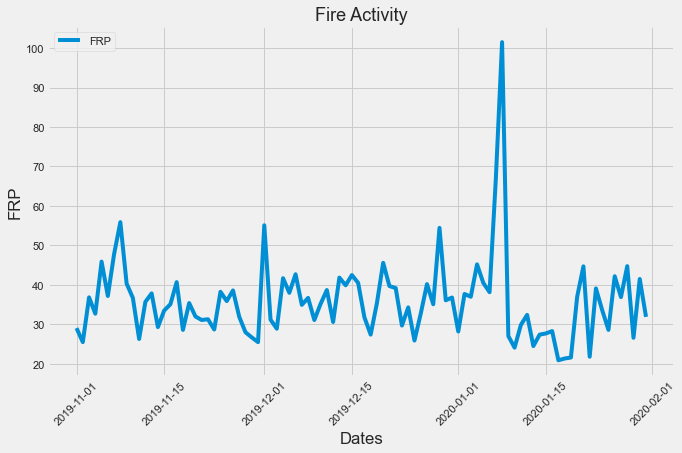

In [104]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(medians_)
plt.xticks(rotation=45);
plt.xlabel('Dates')
plt.ylabel('FRP')
plt.legend(['FRP'], loc=2)
plt.title('Fire Activity', fontsize=18)
plt.style.use('fivethirtyeight')
plt.show()

The above plot shows that the fire activity in Australia was at its peak during the first half of January in 2020.

### _3: Build a model for spatial prediction of wildfire_

The target variable chosen here is Fire Radiative Power - 'frp'

In [96]:
df.describe()
#Pre-processing the data  by Feature engineering using One-Hot Encoding method. This process takes categorical variables such Daynight and converts it to a numerical representation.
df= pd.get_dummies(df)
df.info

<bound method DataFrame.info of         latitude  longitude  brightness  scan  track  acq_time  confidence  \
107560  -19.8433   136.4907       323.0   4.6    2.0       357          68   
61605   -14.4085   130.7216       329.6   1.0    1.0       500          79   
21814   -30.4139   116.1161       320.7   1.7    1.3       204          68   
145239  -20.7226   128.6361       381.6   2.2    1.4       446         100   
121679  -16.4399   128.2831       322.9   1.2    1.1      1354         100   
...          ...        ...         ...   ...    ...       ...         ...   
82745   -13.6533   135.5746       328.7   1.4    1.2       134          82   
11668   -36.4453   149.6510       324.4   1.3    1.1      2349          57   
122281  -12.5477   142.8205       340.6   1.0    1.0       411          83   
93445   -25.5132   152.3535       310.6   1.2    1.1      1225          80   
37446   -36.6417   147.8296       378.7   1.0    1.0        14          94   

        bright_t31    frp  type

### _Supervised Learning_
This is a supervised learning model because we know our target variable. We want to perform a predictive analysis on our target variable using other attributes within the dataset. We will be using feature selection method to shortlist most important features contributing to the predictive analysis of our target variable. 

### _Feature Selection Method - Pearson Correlation_
Feature selection is one of the most important step as part of preprocessing the data. It gives a clarity on the features that contribute in predicting the value of our target variable.
For this purpose, we have chosen 'Pearson Correlation' method. It uses a linear correlation coefficient to predict the dependency between input variable with the target variable.

In [11]:
#Correlation with the output variable - 'frp'
cor_target = abs(corr["frp"])
#Selecting highly correlated features
#Selecting all the features that have a correlation coefficient more than 0.2 to get a list of top features
relevant_features = cor_target[cor_target>0.2]
relevant_features = relevant_features.drop('frp')
relevant_features.sort_values(ascending = False)

brightness    0.623511
bright_t31    0.295359
confidence    0.285345
scan          0.225811
track         0.219417
Name: frp, dtype: float64

### _Random Forest Regression_
This model has been selected as the baseline model. It takes a multiple classifying decision tree each trained on a subset dataset and uses averaging to improve the predictive accuracy and control over-fitting. The use of multiple trees reduces variance.
It uses various parameters,
n_estimators - number of decision trees
max_depth - the number of levels in a decision trees
random_state - controls bootstrapping of the samples used when building trees [8](https://towardsdatascience.com/hypothesis-testing-with-python-step-by-step-hands-on-tutorial-with-practical-examples-e805975ea96e)

In [100]:
import numpy as np

labels = np.array(df['frp'])

#Features and targets converted to array
df_updated = df.drop('frp', axis = 1)

df_update_list = list(df_updated.columns)

df_updated = np.array(df_updated.dropna())

labels.shape, df_updated.shape

((200000,), (200000, 1476))

### _Building model_

In [101]:
# Splitting data into training and testing sets to avoid overfitting
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
#To avoid over-fitting, we will divide our dataset into training and test splits, which gives us a better idea as to how our algorithm performed during the testing phase.
train_features, test_features, train_labels, test_labels = train_test_split(df_updated, labels, test_size = 0.25, random_state = 42)

In [102]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (150000, 1476)
Training Labels Shape: (150000,)
Testing Features Shape: (50000, 1476)
Testing Labels Shape: (50000,)


Based on the combination of features generated from the above correlation model, we have used combination of three different features together and observed their predictive algorithm. The best feature combination is selected as final modelling. 

### _Evaluation Metrics_
This evaluation is done using two evaluation metrics i.e Mean Absolute error and Accuracy %.
Mean absolute error is taken into consideration as the error might be high or low depending on the range of values. Due to this reason, we take mean values of all the errors to generalise the error rate. 
Accuracy % is another metric is computed based on mean absolute percentage error. This metrics tells us the performance of our model.

In [16]:
#Iteration 1 - using 'brightness', 'bright_t31', 'confidence'
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Random forest with only the two three important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

important_indices = [df_update_list.index('brightness'), df_update_list.index('bright_t31'), df_update_list.index('confidence')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

#Fitting the model to the data
rf_most_important.fit(train_important, train_labels)

#Once the model has been trained to learn the relationship between input and target variables, we can use it to predict on the test features
predictions = rf_most_important.predict(test_important)

#This is an evaluation metric to calculate mean absolute error
errors = abs(predictions - test_labels)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mae1 = round(np.mean(errors), 2)

mape1 = 100 * (errors / test_labels)

accuracy1 = 100 - np.mean(mape1[np.isfinite(mape1)])

print('Accuracy:', round(accuracy1, 2), '%.')

Mean Absolute Error: 40.73 degrees.
Accuracy: 26.23 %.


/var/folders/vq/4wtg6xvn62n46nswq3p1yg280000gn/T/ipykernel_5020/2077635475.py:22: RuntimeWarning: divide by zero encountered in true_divide
  mape1 = 100 * (errors / test_labels)


In [103]:
#Iteration 2 - using 'brightness', 'bright_t31', 'scan'
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Random forest with only the two three important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

important_indices = [df_update_list.index('brightness'), df_update_list.index('scan'), df_update_list.index('bright_t31')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

rf_most_important.fit(train_important, train_labels)

#Evaluation metrics - Error prediction and accuracy test

predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mae2 = round(np.mean(errors), 2)

mape2 = 100 * (errors / test_labels)

accuracy2 = 100 - np.mean(mape2[np.isfinite(mape2)])

print('Accuracy:', round(accuracy2, 2), '%.')

Mean Absolute Error: 8.3 degrees.
Accuracy: 84.5 %.


/var/folders/vq/4wtg6xvn62n46nswq3p1yg280000gn/T/ipykernel_990/1467353977.py:22: RuntimeWarning: divide by zero encountered in true_divide
  mape2 = 100 * (errors / test_labels)


In [18]:
#Iteration 3 - using 'brightness', 'confidence', 'scan'
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Random forest with only the two three important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

important_indices = [df_update_list.index('brightness'), df_update_list.index('scan'), df_update_list.index('confidence')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

rf_most_important.fit(train_important, train_labels)

#Evaluation metrics - Error prediction and accuracy test

predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mae3 = round(np.mean(errors), 2)

mape3 = 100 * (errors / test_labels)

accuracy3 = 100 - np.mean(mape3[np.isfinite(mape3)])

print('Accuracy:', round(accuracy3, 2), '%.')

Mean Absolute Error: 9.03 degrees.
Accuracy: 81.57 %.


/var/folders/vq/4wtg6xvn62n46nswq3p1yg280000gn/T/ipykernel_5020/2152462989.py:22: RuntimeWarning: divide by zero encountered in true_divide
  mape3 = 100 * (errors / test_labels)


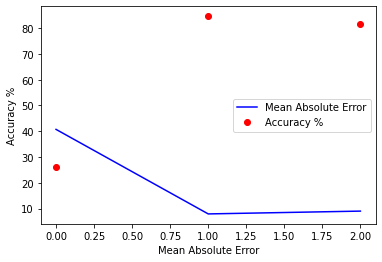

In [19]:
#Visualisation of the evaluation metrics
import matplotlib.pyplot as plt
plt.plot([mae1,mae2,mae3], 'b-', label = 'Mean Absolute Error')
plt.plot([accuracy1, accuracy2, accuracy3], 'ro', label = 'Accuracy %')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Accuracy %')
plt.legend()
plt.show()

After evaluating, iteration 2 has been selected as the ideal feature combination yeilding the highest Accuracy % and the lowest Mean Absolute error. However, we will try to increase the performance of our model by performing hyperparameter tuning.

In general random forest are less likely to cause overfit than other models as they are made of weak classifiers whcih are trained independently. There are ways in which we can avoid overfitting. To avoid overfitting we use hyperparameter tuning model. This is done by - 
1. Reduce tree depth
2. Increase dataset size
3.  Reducing number of variance of samples at each split

### _Hyperparameter tuning the model_
In the case of a random forest, hyperparameters include the number of decision trees in the forest and the number of features considered by each tree when splitting a node. 


In [11]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


Fine tuning the parameters - The most important settings are the number of trees in the forest (n_estimators) and the number of features considered for splitting at each leaf node (max_features)

In [13]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [15]:
#Using the best features selection model 
important_indices = [df_update_list.index('brightness'), df_update_list.index('scan'), df_update_list.index('bright_t31')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

### _K-Cross Validation Random Search Grid_
Using Scikit-Learn’s RandomizedSearchCV method, we can define a grid of hyperparameter ranges, and randomly sample from the grid, performing K-Fold CV with each combination of values.
This K-Fold Cross Validation method, splits our training data into K number of subsets called folds and evaluates the model on K-1 subsets, thus ensuring the model doesn't generalise any predictions and avoids overfitting. 
The most important factor here is 'n_iter' which defines the number of combinations RandomSearchCV fucntion will perform and 'cv' represents the number of folds used for cross validation.[ 

In [113]:
# Using the random grid to search for best hyperparameters
# Creating the base model
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 1, cv = 2, verbose=1, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_important, train_labels)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(), n_iter=1, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=1)

In [20]:
np.seterr(invalid='ignore')
def evaluate(model, test_important, test_labels):
    predictions = model.predict(test_important)
    predictions = predictions[~np.isnan(predictions)]
    errors = abs(predictions - test_labels)
    
    mape = 100 * np.divide(errors, test_labels, out=np.zeros_like(errors), where=test_labels!=0)

    accuracy = 100 - np.nanmean(mape[np.isfinite(mape)])
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(train_important, train_labels)
#Evaluating base model accuracy
base_accuracy = evaluate(base_model, test_important, test_labels)

Model Performance
Average Error: 8.4551 degrees.
Accuracy = 84.11%.


In [21]:
best_random = rf_random.best_estimator_
#Evaluating best parameters from K-Cross validation model
random_accuracy = evaluate(best_random, test_important, test_labels)

#Checking the improvement between the accuracy score between base and random parameters model
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 8.5497 degrees.
Accuracy = 85.05%.
Improvement of 1.11%.


### _Visualisation of training model_
Visualisation model of the learning process by selecting a given desicion tree. The below figure gives us an understanding of how the machine learning model is evaluating the target variable by taking combination of different input variables.

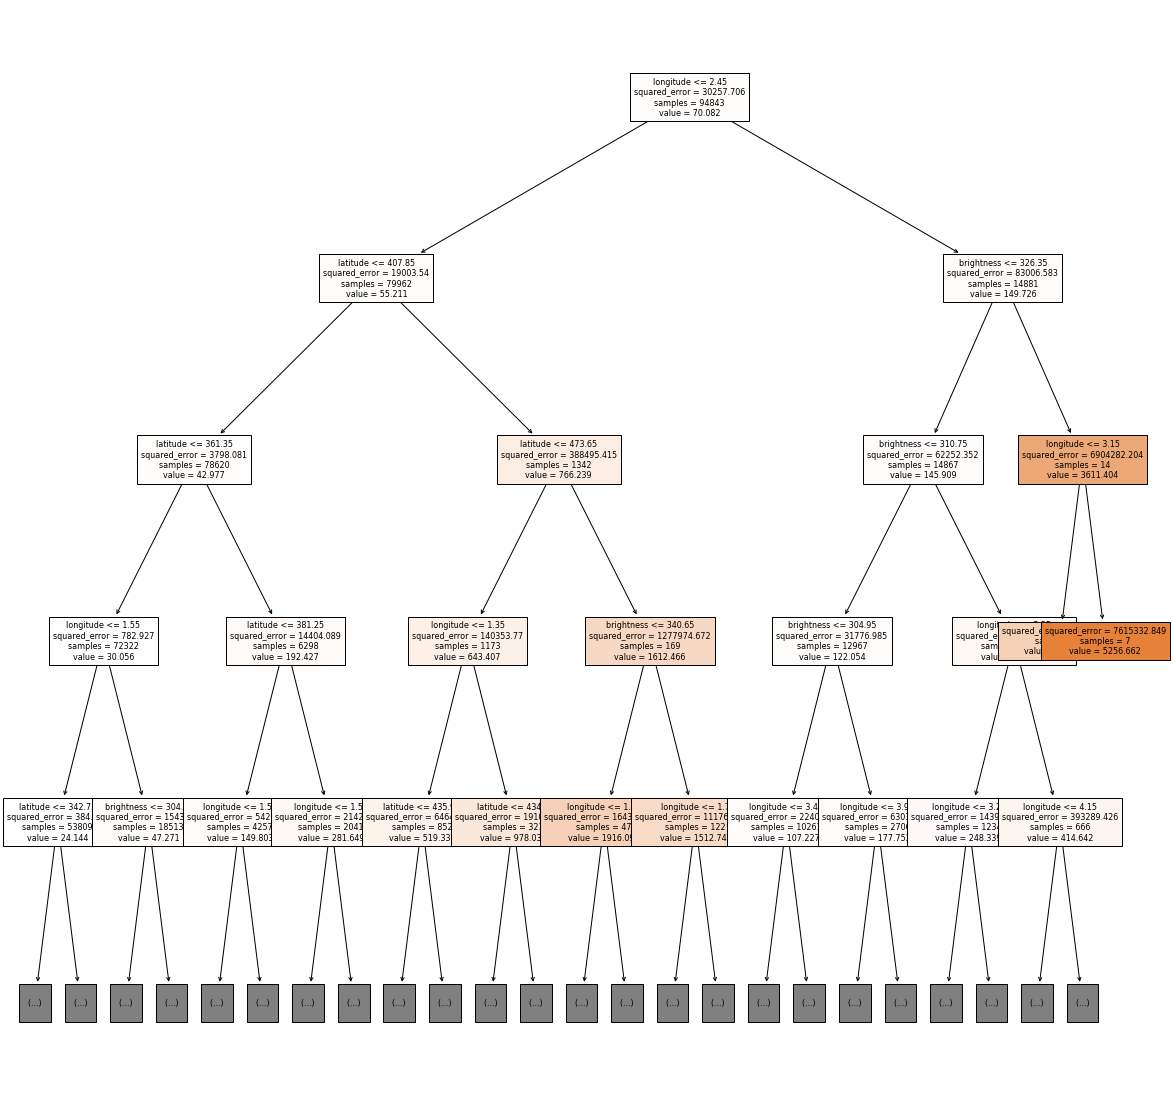

In [22]:
from sklearn import tree
from dtreeviz.trees import dtreeviz # will be used for tree visualization
from matplotlib import pyplot as plt
plt.rcParams.update({'figure.figsize': (20.0, 18.0)})
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(20,20))
_ = tree.plot_tree(rf_random.best_estimator_[0], feature_names=df.columns, filled=True, max_depth = 4, fontsize=8 )
plt.show()

### _Predictive analysis comparison between actual vs predicted values_

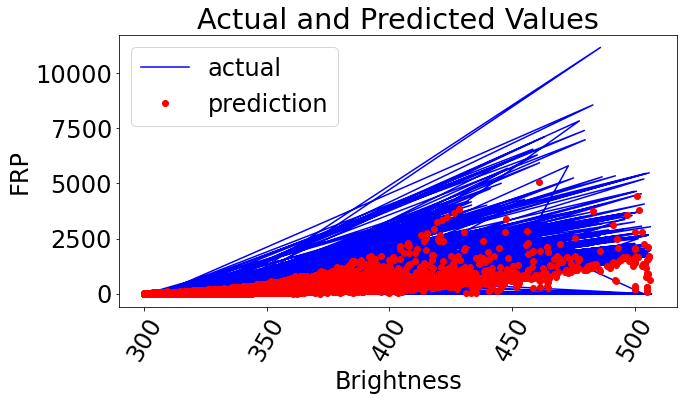

In [108]:
import matplotlib.pyplot as plt

# Training
brightness = df_updated[:, df_update_list.index('brightness')]

# Dataframe with true values
true_data = pd.DataFrame(data = {'brightness': brightness, 'actual': labels})

# Predictions
brightness = test_features[:, df_update_list.index('brightness')]


# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'brightness': brightness, 'prediction': predictions})

# Plot the actual values
plt.figure(figsize=(10,5))
plt.plot(true_data['brightness'], true_data['actual'], 'b-', label = 'actual')
# Plot the predicted values
plt.plot(predictions_data['brightness'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Brightness'); plt.ylabel('FRP'); plt.title('Actual and Predicted Values');




Analysis -
As we saw the baseline model yeilded us satisfactory results with around 85% of accuracy in our predictive values. However, as a candidate final model we will evaluate our results onto another machine learning regression model - Multiple Linear Regression. 

### _Linear regression_
As a candidate final model, we explored a couple of different machine learning algorithms such as K-neighbors classifier, Multiple Linear Regression. For the benefit of the requirement, we have decided to ahead with Linear Regression. The reason behind choosing Linear Regression model is computes the output by determining its relationship with the input variables/ features. This is done using a hypothetical function, defined as h(x)

  h( x ) = w * x + b  
    
  here, b is the bias.
  x represents the feature vector
  w represents the weight vector.

The edge of this model over others is that it uses a cost function to measure the performance of the learning model by quantifying the error difference between expected and values predicted by the model. To ensure this cost function is at its lowest, we use Gradient Descent which a differentiation of the cost function. [9](https://faun.pub/implementing-multiple-linear-regression-from-scratch-in-python-f5d84d4935bb)

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

df = pd.get_dummies(df)

y = np.array(df['frp'])

x = df.iloc[:,:-1].values


/opt/homebrew/lib/python3.9/site-packages/pandas/core/algorithms.py:794: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [32]:
#Preprocessing the data using One-Hot Encoding 
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [3])], remainder='passthrough')
x = np.array(ct.fit_transform(x))

#Scaling the data to fit the model
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x = sc.fit_transform(x)

In [33]:
#Splitting data into training and testing model
Xtrain, Xtest, Ytrain, Ytest = train_test_split( x, y, test_size = 0.3,random_state=42)
Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape

((140000, 1515), (60000, 1515), (140000,), (60000,))

In [34]:
#Defining cost function to calculate weights and bias 
def CostFunction(x,y,w,b):
    cost = np.sum((((x.dot(w) + b) - y) ** 2) / (2*len(y)))
    return cost

#Defining gradient descent function 
def GradientDescent(x, y, w, b, learning_rate, epochs):
    cost_list = [0] * epochs
   
    for epoch in range(epochs):
        z = x.dot(w) + b
        loss = z - y
        
        weight_gradient = x.T.dot(loss) / len(y)
        bias_gradient = np.sum(loss) / len(y)
        
        w = w - learning_rate*weight_gradient
        b = b - learning_rate*bias_gradient
  
        cost = CostFunction(x, y, w, b)
        cost_list[epoch] = cost
        
        if (epoch%(epochs/10)==0):
            print("Cost is:",cost)
        
    return w, b, cost_list


To avoid overfitting, we have ensured that we take a large sample of data subset and train it well on the training data. The large data set will ensure the model does not overfit the data. 

In [78]:
w, b, c= GradientDescent(Xtrain, Ytrain, np.zeros(Xtrain.shape[1]), 0, 0.002,epochs=15000)

Cost is: 16876.81920010454
Cost is: 290.48095075755714
Cost is: 72.3520751011991
Cost is: 29.52855901324164
Cost is: 12.937670115537383
Cost is: 5.800834243922499
Cost is: 2.641582976982013
Cost is: 1.2189056812809855
Cost is: 0.5693664039269559
Cost is: 0.26911837496946395


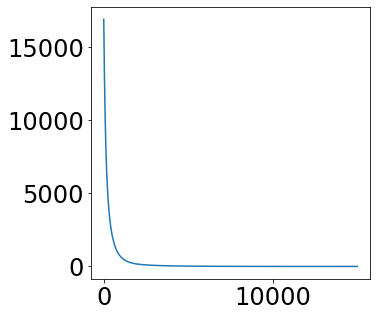

In [90]:
#Plotting cost for each iteration
plt.figure(figsize=(5,5))
plt.plot(c)

In [80]:
#Predict function is used to calculate the accuracy score between the predicted values using wieghts and bias as parameters
def predict(X, w, b):
    return X.dot(w) + b
y_pred = predict(Xtest, w, b)

Evaluation metrics - R-squared score determines the proportion of variance in the dependent variable that can be explained by the independent variable.

R-squared score is used as an evaluation metric here because R-Squared captures the fraction of variance of actual values captured by the regression model and tends to give a better picture of the quality of the regression model

In [81]:
#Calculating accuracy score
def r2score(y_pred, y):
    rss = np.sum((y_pred - y) ** 2)
    tss = np.sum((y-y.mean()) ** 2)
    
    r2 = 1 - (rss / tss)
    return r2
r2score(y_pred, Ytest)

0.9999907077209851

### _Hyperparamter tuning_

As part of hyperparameter tuning, we will search different values for model hyperparameters and choose a subset that results in a model that achieves the best performance on a given dataset.

In [82]:
def mean_squared_error_custom(truth, predicted):
    m = truth.shape[0]
    mse = (np.sum((predicted - truth)**2)) / (2*m)
    return mse
    
def batch_gradient_descent(X, y, lrate, niter):
    weights = np.zeros(X.shape[1])
    
    history = []
    m = len(y)
    
    predict    = lambda x: np.dot(x, weights)
    derivative = lambda loss: (X.T.dot(loss)) / m
    
    for i in range(niter):
        hypothesis = predict(X)
        loss = hypothesis - y
        weights = weights - lrate * derivative(loss)
        
        if i % 50 == 0:
            history.append(mean_squared_error_custom(X.dot(weights), y))

    return predict, history

In [ ]:
import time
#Selecting a range of values for learning rates and number of iterations as part of hyperparameters tuning
lrates = [.01, .001] #10-factor steps
niterations =  [25000, 150000]

def test(X, y):
    record = []
    
    for niter in niterations:
        for lrate in lrates:
            start = time.time()
            weigths, records = batch_gradient_descent(X, y, lrate, niter)
            delta = time.time() - start
            record.append(dict(lrate=lrate, niter=niter, w=weigths, history=records, time=delta))
    
    return record

rec = test(Xtrain, Ytrain)

In [377]:
#This function will create a tabular form of cost incurred for each combination of hyperparameters we have selected
import tabulate
time_sorted_records = sorted(rec, key=lambda k: k['time']) 
tab_data = time_sorted_records.copy()
for r in tab_data:
    r['cost'] = r['history'][-1]
    del r['history']
    del r['w']

print(tabulate.tabulate(time_sorted_records, headers={'lrate': 'lrate', 'niter': 'niter', 'time': 'elapsed time', 'cost': 'cost'}))


  lrate    niter    elapsed time           cost
-------  -------  --------------  -------------
  0.01     25000         112.476    0.000364869
  0.001    25000         117.11   377.659
  0.01    150000         664.327    6.71012e-07
  0.001   150000         780.082    0.0834672


In [378]:
#Taking the lowest cost from above - learning rate = 0.01 and iterations = 150000
w, b, c= GradientDescent(Xtrain, Ytrain, np.zeros(Xtrain.shape[1]), 0, 0.01,epochs=150000)

Cost is: 14869.089382771444
Cost is: 8.390762046421388e-05
Cost is: 4.097133757391119e-05
Cost is: 2.000880945727404e-05
Cost is: 9.771525158883468e-06
Cost is: 4.7720332453975486e-06
Cost is: 2.3304756345529277e-06
Cost is: 1.1381137565432404e-06
Cost is: 5.558105408250712e-07
Cost is: 2.7143627385060264e-07


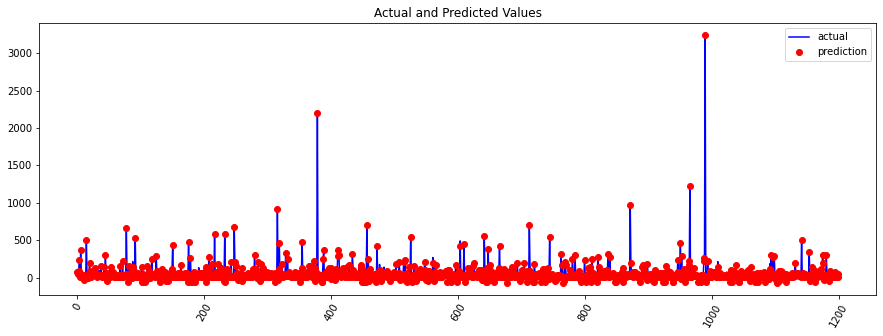

In [380]:
plt.figure(figsize=(15,5))
# Plot the actual values
plt.plot(Ytest, 'b-', label = 'actual')

# Plot the predicted values
plt.plot(y_pred , 'ro', label = 'prediction')

plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels 
plt.title('Actual and Predicted Values');

As we can see from the above image that Linear Regression performs much better than Random Forest in terms of predicting the values for our target variable and giving a r-squared accuracy score of 0.99! 
Hence, this mode can be considered as our final model to perform supervised regression predictive modelling.

### _Statistical Significance Testing_ 
As part of statistical testing we evalute both our models and draw a comparison between them by evaluating accuracy scores.[10](https://machinelearningmastery.com/hypothesis-test-for-comparing-machine-learning-algorithms)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

labels = np.array(df['frp'])

df_updated = df.drop('frp', axis = 1)

train_features, test_features, train_labels, test_labels = train_test_split(df_updated, labels, test_size = 0.25, random_state = 42)

important_indices = [df_update_list.index('brightness'), df_update_list.index('scan'), df_update_list.index('bright_t31')]
train_important = train_features[["brightness", "scan", "confidence"]]
test_important = test_features[["brightness", "scan", "confidence"]]


rf = RandomForestRegressor()
lr = LinearRegression()

score1 = rf.fit(train_important, train_labels).score(test_important, test_labels)
score2 = lr.fit(train_important, train_labels).score(test_important, test_labels)

We will perform paired t-test to compute t statistic and p-value. 
As part of this test we will split our data into training and testing data and fit our models on the data and repeat this process for a total of 5 iterations. Then we rotate testing and training data set and compute the performance again. The t statistic assumes that the distribution with 5 degrees of freedom means both the models are behaving similar. If the degree of freedom between the models is less than 5 degrees that means model are behaving significantly different. This degree is denoted as p-value.

If p-value < 0.05 then both the models are performing significantly different. If the p-value is above 0.05, then both the models are performing similarly. 

In [499]:
#Using  paired_ttest_5x2cv to and evaluate p-value
from mlxtend.evaluate import paired_ttest_5x2cv


t, p = paired_ttest_5x2cv(estimator1=rf,
                          estimator2=lr,
                          X=df_updated[["brightness", "scan", "confidence"]], y=labels,
                          random_seed=1)

print('t statistic: %.3f' % t)
print('p value: %f' % p)

t statistic: 12.737
p value: 0.000053


Since p-value is less than 0.05, we can evaluate that both the models are performing significantly different.
Now we go ahead to plot these scores using a box plot.

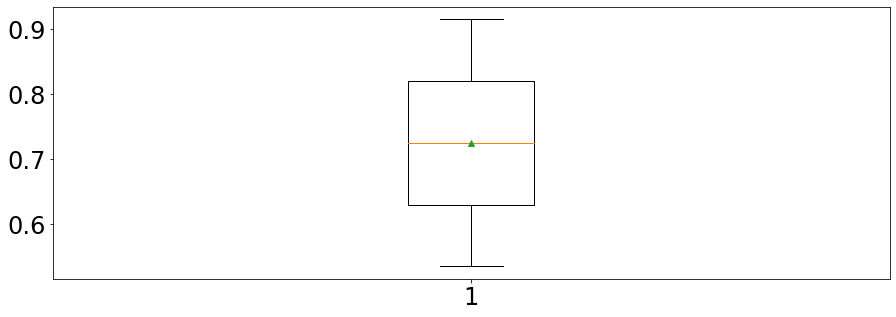

In [95]:
#Plotting the results using a box plot to compare the scores
# plot the results
from matplotlib import pyplot
plt.figure(figsize=(15,5))
pyplot.boxplot([score1, score2], showmeans=True)
pyplot.show()

### _References_

[1] https://github.com/ydataai/pandas-profiling

[2] https://stackoverflow.com/questions/32012012/pandas-resample-timeseries-with-groupby

[3] https://towardsdatascience.com/the-easiest-way-to-plot-data-from-pandas-on-a-world-map-1a62962a27f3

[4] https://stackoverflow.com/questions/54752175/add-heatmap-to-a-layer-in-folium

[5] https://stackoverflow.com/questions/53721079/python-folium-icon-list

[6] https://stackoverflow.com/questions/59631533/pandas-counting-rows-with-dates

[7] https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas 

[8] https://towardsdatascience.com/hypothesis-testing-with-python-step-by-step-hands-on-tutorial-with-practical-examples-e805975ea96e

[9] https://faun.pub/implementing-multiple-linear-regression-from-scratch-in-python-f5d84d4935bb

[10] https://machinelearningmastery.com/hypothesis-test-for-comparing-machine-learning-algorithms/

[11] https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

[12] https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

